# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


##  Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
#TO SUPRESS WARNINGS
import warnings
warnings.filterwarnings("ignore")

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [1]:
%matplotlib inline

import re
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import f1_score,classification_report
from sklearn.metrics import log_loss, precision_score, recall_score
from sklearn import datasets, neighbors
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit

C:\Users\JAYESH\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

#  Exploratory Data Analysis

## Data Cleaning: Deduplication

#It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
7. Finally Lemmatization as it gives better result than stemming<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [12]:

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [ ]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
      
                    s=(wnl.lemmatize(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
              
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [ ]:
final['CleanedTextMe']=final_string 

In [ ]:

#SAVING PREPROCESSED DATA IN PICKLE FILE FOR LATER USE
final.to_pickle('amazon_food_review_after_preprocess_v2')

In [7]:
data  = pd.read_pickle("amazon_food_review_after_preprocess_v2")

# BAG OF WORDS

Using <b> Bi-Gram </b>. We can make use of group of words to get better results. Sometimes sequence of words might have different effect on the prediction. Sequences like "not good" or "not bad" affect the prediction in way different than when used individually.

In [8]:
CleanedTextMe = data['CleanedTextMe']

In [9]:
polarity = data['Score']

In [10]:
#SPLITTING(TIME BASED SPLIT) TRAIN AND TEST DATA 
x_train = CleanedTextMe.iloc[:254920]
x_test = CleanedTextMe.iloc[254920:]
y_train = polarity.iloc[:254920]
y_test = polarity.iloc[254920:]

In [34]:
#TRAINING VECTORIZER ON TRAIN DATA
count_vect = CountVectorizer(ngram_range=(1,2)) #scikit-learn countevectorizer (bi-gram)
final_counts = count_vect.fit_transform(x_train.values)

In [35]:
final_counts

<254920x2294007 sparse matrix of type '<class 'numpy.int64'>'
	with 25680663 stored elements in Compressed Sparse Row format>

In [36]:
#STORING VOCABULARY
cnt_vect_feat = count_vect.get_feature_names()

In [37]:
#TRAINING VECTORIZER ON TEST DATA USING VECTORS OBTAINED FROM TRAIN DATA
count_vect_test = CountVectorizer(ngram_range=(1,2),vocabulary=cnt_vect_feat) #scikit-learn countevectorizer
final_counts_test = count_vect_test.transform(x_test.values)

In [38]:
final_counts_test

<109251x2294007 sparse matrix of type '<class 'numpy.int64'>'
	with 10556699 stored elements in Compressed Sparse Row format>

In [12]:
tscv_data = TimeSeriesSplit(n_splits=10)

In [13]:
alpha = list(np.arange(0.01,1,0.01))

In [14]:
cv_scores= []

# 1. BINOMIAL NAIVE BAYES

In [ ]:
for a in alpha:
    clf = BernoulliNB(alpha=a)
    cv_score_temp = []
    #print("alpha:",a)
    for train_index, test_index in tscv_data.split(final_counts):
        
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = final_counts[train_index], final_counts[test_index]
        #print(X_train,":",X_test)
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        clf.fit(X_train, Y_train)
        prd = clf.predict(X_test)
        acc = accuracy_score(Y_test, prd, normalize=True)
        cv_score_temp.append(acc)
        
    tmp = np.asarray(cv_score_temp)
    avg = np.sum(tmp)/10
    #print("acc:",avg)
    cv_scores.append(avg)

In [ ]:
cv_scr_df = pd.DataFrame(cv_scores)
cv_scr_df.to_pickle("cv_score_NB_BOW_2")

In [13]:
cv_scr_tmp = pd.read_pickle("cv_score_NB_BOW_2")

In [14]:
cv_scores = cv_scr_tmp[0].tolist()


The optimal number of neighbors is 0.010000.


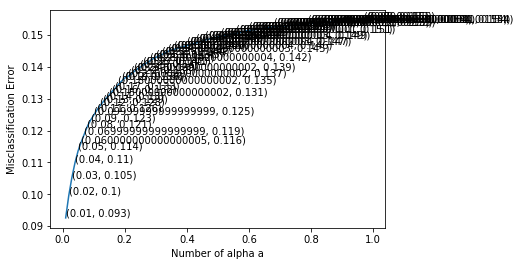

the misclassification error for each alpha value is :  [0.093 0.1   0.105 0.11  0.114 0.116 0.119 0.121 0.123 0.125 0.126 0.128
 0.129 0.13  0.131 0.132 0.133 0.135 0.136 0.136 0.137 0.138 0.139 0.139
 0.14  0.141 0.141 0.142 0.142 0.143 0.143 0.144 0.144 0.145 0.145 0.146
 0.146 0.146 0.146 0.147 0.147 0.147 0.148 0.148 0.148 0.149 0.149 0.149
 0.149 0.149 0.15  0.15  0.15  0.15  0.15  0.151 0.151 0.151 0.151 0.152
 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.153 0.153 0.153 0.153 0.153
 0.153 0.153 0.153 0.153 0.153 0.153 0.154 0.154 0.154 0.154 0.154 0.154
 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154
 0.155 0.155 0.155]


In [15]:
#Misclassification error for each alpha
MSE = [1 - x for x in cv_scores]

#find optimal alpha for which misclassification error is low
optimal_alpha = alpha[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %f.' % optimal_alpha)


plt.plot(alpha, MSE)

for xy in zip(alpha, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of alpha a')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [29]:
# ------------ Naive Bayes with optimal ALPHA--------------###
optimal_nb = BernoulliNB(alpha=optimal_alpha)
lp = optimal_nb.fit(final_counts, y_train)
prd = optimal_nb.predict(final_counts_test)

In [30]:
acc = accuracy_score(y_test, prd) * 100
print('\nThe accuracy of the NB IS:' , acc)


The accuracy of the NB IS: 91.46460901959708


In [20]:
print(classification_report(y_test,prd))

             precision    recall  f1-score   support

   negative       0.86      0.61      0.71     19081
   positive       0.92      0.98      0.95     90170

avg / total       0.91      0.91      0.91    109251



 <b>Confusion Matrix</b>

In [22]:
#y_test_np= np.asarray(y_test)
mat = confusion_matrix(y_test,prd)
tn, fp, fn, tp = confusion_matrix(y_test,prd).ravel()

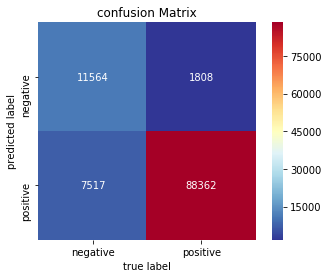

In [53]:
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap='RdYlBu_r',
            xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title("confusion Matrix")
plt.xlabel('true label')
plt.ylabel('predicted label');

In [24]:
print(tn, fp, fn, tp)

11564 7517 1808 88362


In [25]:
print("True positive rate:",(tp/(tp+fp))*100)
print("False positive rate:",(fp/(tp+fp))*100)
print("True negative rate:",(tn/(tn+fn))*100)
print("False negative rate:",(fn/(tn+fn))*100)


True positive rate: 92.15990988641934
False positive rate: 7.840090113580659
True negative rate: 86.47921029015853
False negative rate: 13.520789709841461


## <b> List of top 10 words that are differ in positive and negative reviews.

1. Words which separate Positive reviews from negative reviews

In [26]:
import operator
diff = optimal_nb.feature_log_prob_[1,:] - optimal_nb.feature_log_prob_[0,:]
name_diff = {}
for i in range(len(cnt_vect_feat)):
    name_diff[cnt_vect_feat[i]] = diff[i]
names_diff_sorted = sorted(name_diff.items(), key = operator.itemgetter(1), reverse = True)
for i in range(10):
    print(names_diff_sorted[i])

('try youll', 8.780353739480454)
('only negative', 8.59100504340498)
('only drawback', 8.561251766047736)
('go great', 8.534040128203003)
('become favorite', 8.187183481494863)
('more soon', 8.187183481494863)
('rebecca review', 8.126866724092494)
('definitely ordering', 8.111201425412819)
('recommend highly', 8.084534600729889)
('thanks much', 8.04596445154772)


2. Words helps to separate Negative reviews from Positive reviews

In [27]:
import operator
diff = optimal_nb.feature_log_prob_[0,:] - optimal_nb.feature_log_prob_[1,:]
name_diff = {}
for i in range(len(cnt_vect_feat)):
    name_diff[cnt_vect_feat[i]] = diff[i]
names_diff_sorted = sorted(name_diff.items(), key = operator.itemgetter(1), reverse = True)
for i in range(10):
    print(names_diff_sorted[i])

('have listened', 9.872870247936907)
('stuff terrible', 9.747746308370079)
('terrible product', 9.67877723818982)
('again nor', 9.604696728378364)
('negative star', 9.604696728378364)
('worst product', 9.604696728378364)
('stuff awful', 9.565491393807331)
('this disgusting', 9.524686059150966)
('worst one', 9.391214163774713)
('refund this', 9.342447797513445)


# 2. MULTINOMIAL NAIVE BAYES

In [ ]:
for a in alpha:
    clf = MultinomialNB(alpha=a)
    cv_score_temp = []
    #print("alpha:",a)
    for train_index, test_index in tscv_data.split(final_counts):
        
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = final_counts[train_index], final_counts[test_index]
        #print(X_train,":",X_test)
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        clf.fit(X_train, Y_train)
        prd = clf.predict(X_test)
        acc = accuracy_score(Y_test, prd, normalize=True)
        cv_score_temp.append(acc)
        
    tmp = np.asarray(cv_score_temp)
    avg = np.sum(tmp)/10
    #print("acc:",avg)
    cv_scores.append(avg)

In [15]:
cv_scr_df = pd.DataFrame(cv_scores)
cv_scr_df.to_pickle("cv_score_NB_BOW_2")

In [22]:
cv_scr_tmp = pd.read_pickle("cv_score_NB_BOW")

In [24]:
cv_scores = cv_scr_tmp[0].tolist()


The optimal number of neighbors is 0.010000.


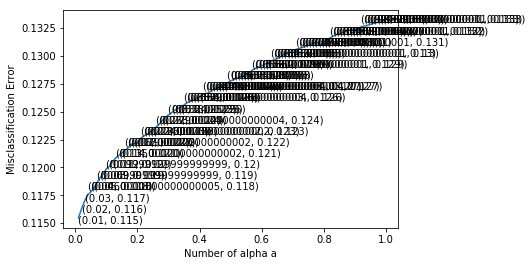

the misclassification error for each alpha value is :  [0.115 0.116 0.117 0.118 0.118 0.118 0.119 0.119 0.119 0.12  0.12  0.12
 0.121 0.121 0.121 0.122 0.122 0.122 0.122 0.122 0.123 0.123 0.123 0.123
 0.123 0.124 0.124 0.124 0.124 0.125 0.125 0.125 0.125 0.125 0.126 0.126
 0.126 0.126 0.126 0.126 0.127 0.127 0.127 0.127 0.127 0.127 0.127 0.127
 0.128 0.128 0.128 0.128 0.128 0.128 0.128 0.128 0.129 0.129 0.129 0.129
 0.129 0.129 0.13  0.13  0.13  0.13  0.13  0.13  0.13  0.13  0.131 0.131
 0.131 0.131 0.131 0.131 0.131 0.131 0.131 0.131 0.131 0.132 0.132 0.132
 0.132 0.132 0.132 0.132 0.132 0.132 0.132 0.133 0.133 0.133 0.133 0.133
 0.133 0.133 0.133]


In [25]:
#Misclassification error for each alpha
MSE = [1 - x for x in cv_scores]

#find optimal alpha for which misclassification error is low
optimal_alpha = alpha[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %f.' % optimal_alpha)


plt.plot(alpha, MSE)

for xy in zip(alpha, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of alpha a')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [26]:
# ------------ Naive Bayes with optimal ALPHA--------------###
optimal_nb = MultinomialNB(alpha=optimal_alpha)
lp = optimal_nb.fit(final_counts, y_train)
prd = optimal_nb.predict(final_counts_test)

In [27]:
acc = accuracy_score(y_test, prd) * 100
print('\nThe accuracy of the NB IS:' , acc)


The accuracy of the NB IS: 91.692524553551


In [28]:
print(classification_report(y_test,prd))

             precision    recall  f1-score   support

   negative       0.83      0.66      0.74     19081
   positive       0.93      0.97      0.95     90170

avg / total       0.91      0.92      0.91    109251



<b>Confusion Matrix</b>

In [29]:
#y_test_np= np.asarray(y_test)
mat = confusion_matrix(y_test,prd)
tn, fp, fn, tp = confusion_matrix(y_test,prd).ravel()

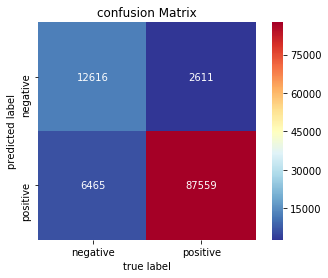

In [30]:
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap='RdYlBu_r',
            xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title("confusion Matrix")
plt.xlabel('true label')
plt.ylabel('predicted label');

In [31]:
print("True positive rate:",(tp/(tp+fp))*100)
print("False positive rate:",(fp/(tp+fp))*100)
print("True negative rate:",(tn/(tn+fn))*100)
print("False negative rate:",(fn/(tn+fn))*100)


True positive rate: 93.1240959754956
False positive rate: 6.875904024504381
True negative rate: 82.85282721481579
False negative rate: 17.14717278518421


# <b> List of top 10 words that are differ in positive and negative reviews.

1. Words which separate Positive reviews from negative reviews

In [32]:
import operator
diff = optimal_nb.feature_log_prob_[1,:] - optimal_nb.feature_log_prob_[0,:]
name_diff = {}
for i in range(len(cnt_vect_feat)):
    name_diff[cnt_vect_feat[i]] = diff[i]
names_diff_sorted = sorted(name_diff.items(), key = operator.itemgetter(1), reverse = True)
for i in range(10):
    print(names_diff_sorted[i])

('try youll', 8.889211097594707)
('only negative', 8.699862401519233)
('only drawback', 8.67010912416199)
('go great', 8.646339712014854)
('become favorite', 8.296040839609116)
('more soon', 8.296040839609116)
('rebecca review', 8.235724082206747)
('definitely ordering', 8.225307863869675)
('recommend highly', 8.193391958844142)
('thanks much', 8.160423751374731)


2. Words helps to separate Negative reviews from Positive reviews

In [33]:
import operator
diff = optimal_nb.feature_log_prob_[0,:] - optimal_nb.feature_log_prob_[1,:]
name_diff = {}
for i in range(len(cnt_vect_feat)):
    name_diff[cnt_vect_feat[i]] = diff[i]
names_diff_sorted = sorted(name_diff.items(), key = operator.itemgetter(1), reverse = True)
for i in range(10):
    print(names_diff_sorted[i])

('have listened', 9.764012889822652)
('stuff terrible', 9.638888950255824)
('terrible product', 9.569919880075567)
('negative star', 9.533565458608074)
('again nor', 9.49583937026411)
('worst product', 9.49583937026411)
('stuff awful', 9.456634035693076)
('this disgusting', 9.41582870103671)
('worst one', 9.282356805660458)
('refund this', 9.23359043939919)


## TF-IDF

In [39]:
#TRAINING TF-IDF VECTORIZER ON TRAIN DATA
count_vect_tfidf_train = TfidfVectorizer(ngram_range=(1,2)) #scikit-learn countevectorizer (bi-gram)
final_counts = count_vect_tfidf_train.fit_transform(x_train.values)

In [40]:
cnt_vect_feat = count_vect_tfidf_train.get_feature_names()

In [42]:
final_counts

<254920x2294007 sparse matrix of type '<class 'numpy.float64'>'
	with 25680663 stored elements in Compressed Sparse Row format>

In [44]:
#TRAINING VECTORIZER ON TEST DATA USING VECTORS OBTAINED FROM TRAIN DATA
count_vect_tfidf_test = TfidfVectorizer(ngram_range=(1,2),vocabulary=cnt_vect_feat) #scikit-learn countevectorizer
final_counts_test = count_vect_tfidf_test.transform(x_test.values)

In [45]:
final_counts_test

<109251x2294007 sparse matrix of type '<class 'numpy.float64'>'
	with 10556699 stored elements in Compressed Sparse Row format>

In [37]:
tscv_data = TimeSeriesSplit(n_splits=10)

In [38]:
alpha = list(np.arange(0.01,1,0.01))

In [39]:
cv_scores= []

# BINOMIAL NAIVE BAYES

In [ ]:
for a in alpha:
    clf = BernoulliNB(alpha=a)
    cv_score_temp = []
    #print("alpha:",a)
    for train_index, test_index in tscv_data.split(final_counts):
        
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = final_counts[train_index], final_counts[test_index]
        #print(X_train,":",X_test)
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        clf.fit(X_train, Y_train)
        prd = clf.predict(X_test)
        acc = accuracy_score(Y_test, prd, normalize=True)
        cv_score_temp.append(acc)
        
    tmp = np.asarray(cv_score_temp)
    avg = np.sum(tmp)/10
    #print("acc:",avg)
    cv_scores.append(avg)

In [ ]:
cv_scr_df = pd.DataFrame(cv_scores)
cv_scr_df.to_pickle("cv_score_NB_tf_idf_2")

In [ ]:
cv_scr_tmp = pd.read_pickle("cv_score_NB_tf_idf_2")

In [ ]:
cv_scores = cv_scr_tmp[0].tolist()


The optimal number of neighbors is 0.010000.


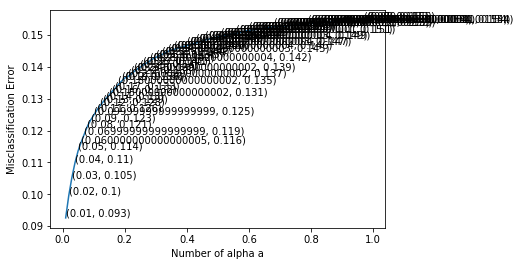

the misclassification error for each alpha value is :  [0.093 0.1   0.105 0.11  0.114 0.116 0.119 0.121 0.123 0.125 0.126 0.128
 0.129 0.13  0.131 0.132 0.133 0.135 0.136 0.136 0.137 0.138 0.139 0.139
 0.14  0.141 0.141 0.142 0.142 0.143 0.143 0.144 0.144 0.145 0.145 0.146
 0.146 0.146 0.146 0.147 0.147 0.147 0.148 0.148 0.148 0.149 0.149 0.149
 0.149 0.149 0.15  0.15  0.15  0.15  0.15  0.151 0.151 0.151 0.151 0.152
 0.152 0.152 0.152 0.152 0.152 0.152 0.152 0.153 0.153 0.153 0.153 0.153
 0.153 0.153 0.153 0.153 0.153 0.153 0.154 0.154 0.154 0.154 0.154 0.154
 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154 0.154
 0.155 0.155 0.155]


In [50]:
#Misclassification error for each alpha
MSE = [1 - x for x in cv_scores]

#find optimal alpha for which misclassification error is low
optimal_alpha = alpha[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %f.' % optimal_alpha)


plt.plot(alpha, MSE)

for xy in zip(alpha, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of alpha a')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [60]:
# ------------ Naive Bayes with optimal ALPHA--------------###
optimal_nb = BernoulliNB(alpha=optimal_alpha)
lp = optimal_nb.fit(final_counts, y_train)
prd = optimal_nb.predict(final_counts_test)

In [62]:
acc = accuracy_score(y_test, prd) * 100
print('\nThe accuracy of the Binomial Naive Bayes is:' , acc)


The accuracy of the Binomial Naive Bayes is: 91.46460901959708


In [50]:
print(classification_report(y_test,prd))

             precision    recall  f1-score   support

   negative       0.86      0.61      0.71     19081
   positive       0.92      0.98      0.95     90170

avg / total       0.91      0.91      0.91    109251



 <b>Confusion Matrix</b>

In [51]:
#y_test_np= np.asarray(y_test)
mat = confusion_matrix(y_test,prd)
tn, fp, fn, tp = confusion_matrix(y_test,prd).ravel()

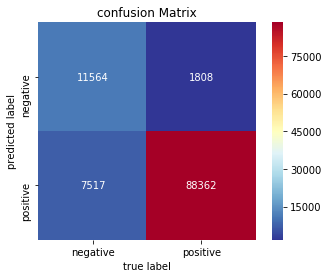

In [52]:
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap='RdYlBu_r',
            xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title("confusion Matrix")
plt.xlabel('true label')
plt.ylabel('predicted label');

In [54]:
print("True positive rate:",(tp/(tp+fp))*100)
print("False positive rate:",(fp/(tp+fp))*100)
print("True negative rate:",(tn/(tn+fn))*100)
print("False negative rate:",(fn/(tn+fn))*100)

True positive rate: 92.15990988641934
False positive rate: 7.840090113580659
True negative rate: 86.47921029015853
False negative rate: 13.520789709841461


## <b> List of top 10 words that are differ in positive and negative reviews.

1. Words which separate Positive reviews from negative reviews

In [55]:
import operator
diff = optimal_nb.feature_log_prob_[1,:] - optimal_nb.feature_log_prob_[0,:]
name_diff = {}
for i in range(len(cnt_vect_feat)):
    name_diff[cnt_vect_feat[i]] = diff[i]
names_diff_sorted = sorted(name_diff.items(), key = operator.itemgetter(1), reverse = True)
for i in range(10):
    print(names_diff_sorted[i])

('try youll', 8.780353739480454)
('only negative', 8.59100504340498)
('only drawback', 8.561251766047736)
('go great', 8.534040128203003)
('become favorite', 8.187183481494863)
('more soon', 8.187183481494863)
('rebecca review', 8.126866724092494)
('definitely ordering', 8.111201425412819)
('recommend highly', 8.084534600729889)
('thanks much', 8.04596445154772)


2. Words helps to separate Negative reviews from Positive reviews


In [56]:
import operator
diff = optimal_nb.feature_log_prob_[0,:] - optimal_nb.feature_log_prob_[1,:]
name_diff = {}
for i in range(len(cnt_vect_feat)):
    name_diff[cnt_vect_feat[i]] = diff[i]
names_diff_sorted = sorted(name_diff.items(), key = operator.itemgetter(1), reverse = True)
for i in range(10):
    print(names_diff_sorted[i])

('have listened', 9.872870247936907)
('stuff terrible', 9.747746308370079)
('terrible product', 9.67877723818982)
('again nor', 9.604696728378364)
('negative star', 9.604696728378364)
('worst product', 9.604696728378364)
('stuff awful', 9.565491393807331)
('this disgusting', 9.524686059150966)
('worst one', 9.391214163774713)
('refund this', 9.342447797513445)


# MULTINOMIAL NAIVE BAYES

In [ ]:
for a in alpha:
    clf = MultinomialNB(alpha=a)
    cv_score_temp = []
    #print("alpha:",a)
    for train_index, test_index in tscv_data.split(final_counts):
        
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = final_counts[train_index], final_counts[test_index]
        #print(X_train,":",X_test)
        Y_train, Y_test = y_train.iloc[train_index], y_train.iloc[test_index]
        clf.fit(X_train, Y_train)
        prd = clf.predict(X_test)
        acc = accuracy_score(Y_test, prd, normalize=True)
        cv_score_temp.append(acc)
        
    tmp = np.asarray(cv_score_temp)
    avg = np.sum(tmp)/10
    #print("acc:",avg)
    cv_scores.append(avg)

In [ ]:
cv_scr_df = pd.DataFrame(cv_scores)
cv_scr_df.to_pickle("cv_score_NB_tf_idf_2")

In [41]:
cv_scr_tmp = pd.read_pickle("cv_score_NB_tfidf")

In [42]:
cv_scores = cv_scr_tmp[0].tolist()


The optimal number of neighbors is 0.010000.


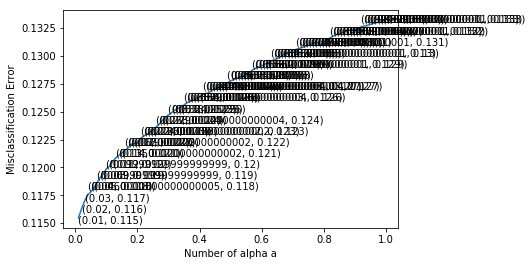

the misclassification error for each alpha value is :  [0.115 0.116 0.117 0.118 0.118 0.118 0.119 0.119 0.119 0.12  0.12  0.12
 0.121 0.121 0.121 0.122 0.122 0.122 0.122 0.122 0.123 0.123 0.123 0.123
 0.123 0.124 0.124 0.124 0.124 0.125 0.125 0.125 0.125 0.125 0.126 0.126
 0.126 0.126 0.126 0.126 0.127 0.127 0.127 0.127 0.127 0.127 0.127 0.127
 0.128 0.128 0.128 0.128 0.128 0.128 0.128 0.128 0.129 0.129 0.129 0.129
 0.129 0.129 0.13  0.13  0.13  0.13  0.13  0.13  0.13  0.13  0.131 0.131
 0.131 0.131 0.131 0.131 0.131 0.131 0.131 0.131 0.131 0.132 0.132 0.132
 0.132 0.132 0.132 0.132 0.132 0.132 0.132 0.133 0.133 0.133 0.133 0.133
 0.133 0.133 0.133]


In [43]:
#Misclassification error for each alpha
MSE = [1 - x for x in cv_scores]

#find optimal alpha for which misclassification error is low
optimal_alpha = alpha[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %f.' % optimal_alpha)


plt.plot(alpha, MSE)

for xy in zip(alpha, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of alpha a')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))

In [45]:
# ------------ Naive Bayes with optimal ALPHA--------------###
optimal_nb = MultinomialNB(alpha=0.01)
lp = optimal_nb.fit(final_counts, y_train)
prd = optimal_nb.predict(final_counts_test)

In [46]:
acc = accuracy_score(y_test, prd) * 100
print('\nThe accuracy of the Binomial Naive Bayes is:' , acc)


The accuracy of the Binomial Naive Bayes is: 90.77170918343997


In [47]:
print(classification_report(y_test,prd))

             precision    recall  f1-score   support

   negative       0.91      0.52      0.66     19081
   positive       0.91      0.99      0.95     90170

avg / total       0.91      0.91      0.90    109251



<b> CONFUSION MATRIX </b>

In [48]:
#y_test_np= np.asarray(y_test)
mat = confusion_matrix(y_test,prd)
tn, fp, fn, tp = confusion_matrix(y_test,prd).ravel()

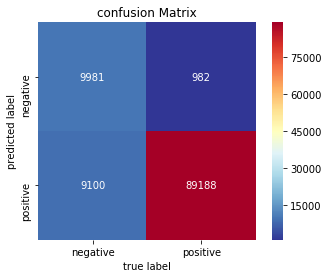

In [49]:
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,cmap='RdYlBu_r',
            xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title("confusion Matrix")
plt.xlabel('true label')
plt.ylabel('predicted label');

In [50]:
print("True positive rate:",(tp/(tp+fp))*100)
print("False positive rate:",(fp/(tp+fp))*100)
print("True negative rate:",(tn/(tn+fn))*100)
print("False negative rate:",(fn/(tn+fn))*100)

True positive rate: 90.74149438385155
False positive rate: 9.258505616148462
True negative rate: 91.04259782906139
False negative rate: 8.957402170938613


#  <b> List of top 10 words that are differ in positive and negative reviews.

1. Words which separate Positive reviews from negative reviews

In [51]:
import operator
diff = optimal_nb.feature_log_prob_[1,:] - optimal_nb.feature_log_prob_[0,:]
name_diff = {}
for i in range(len(cnt_vect_feat)):
    name_diff[cnt_vect_feat[i]] = diff[i]
names_diff_sorted = sorted(name_diff.items(), key = operator.itemgetter(1), reverse = True)
for i in range(10):
    print(names_diff_sorted[i])

('try youll', 6.663824912544822)
('go great', 6.446543802379443)
('only drawback', 6.34060557457485)
('more soon', 6.294855768382337)
('only negative', 6.279167119959832)
('thanks much', 6.225102191691612)
('become favorite', 6.174423217686163)
('recommend highly', 6.108091055514668)
('definitely ordering', 6.100975554136969)
('exactly described', 6.059583056533089)


2. Words helps to separate Negative reviews from Positive reviews


In [53]:
import operator
diff = optimal_nb.feature_log_prob_[0,:] - optimal_nb.feature_log_prob_[1,:]
name_diff = {}
for i in range(len(cnt_vect_feat)):
    name_diff[cnt_vect_feat[i]] = diff[i]
names_diff_sorted = sorted(name_diff.items(), key = operator.itemgetter(1), reverse = True)
for i in range(10):
    print(names_diff_sorted[i])

('stuff terrible', 7.789310430148895)
('have listened', 7.695423342532953)
('terrible product', 7.642510106221799)
('worst product', 7.514986101233827)
('stuff awful', 7.473828494625561)
('again nor', 7.421308074246742)
('were moldy', 7.391186451833828)
('negative star', 7.362007238938654)
('seemed stale', 7.340618931940625)
('this disgusting', 7.324093425568261)


# Conclusion:

    1.Binomial Naive Bayes works slightly better than Multinomial Naive Bayes as we got 91.46% accuracy with binomial     Naive Bayes. 
    2.We got avergae f1 score of 91% which is fairly well.
    3.We got same accuracy with both vectorizers Bag Of Words and Tf-IDF because Naive Bayes is counting based technique and calcukates likelihood probability of each point rather base don their appearance in the training.
    4.We got a considerably good TRUE POSITIVE RATE, FALSE POSITIVE RATE, TRUE NEGATIVE RATE AND FALSE NEGATIVE RATE in         Multinomial Naive Bayes on TF-IDF.